In [2]:
import torch
import torch.optim as optim
from torch.autograd import Variable

# cuda settings
USE_CUDA = torch.cuda.is_available()

def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

print('Using CUDA:',USE_CUDA)

Using CUDA: False


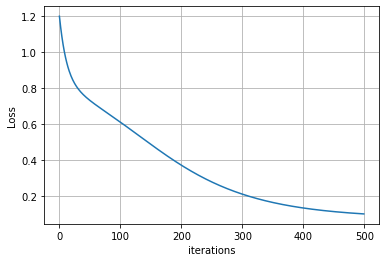

In [6]:
import numpy as np
from matplotlib import pyplot as plt
inputs = np.array([[-1,0],[0,1],[4,4],[2,3]])
targets = np.array([-1,-1,+1,+1])
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
H, D_out = 2, 1
x = toTensor(inputs)
y = toTensor(targets)
N,D_in = x.shape
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Sigmoid(),
    torch.nn.Linear(H, D_out),
)
model=cuda(model)
# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
L = []

for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x).flatten()
    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    L.append(loss.item())
    # Zero the gradients before running the backward pass.
    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    model.zero_grad()
    loss.backward()
    optimizer.step()
plt.plot(L);plt.xlabel('iterations');plt.ylabel('Loss');plt.grid()

In [22]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from tqdm.notebook import tqdm
USE_CUDA = torch.cuda.is_available()
from torch.autograd import Variable

def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):
    vec = v.clone().detach()
    return cuda(Variable(vec).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

# Hyper Parameters
input_size = 784 #number of features
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST Dataset
train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Neural Network Model (1 hidden layer)
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = cuda(Net(input_size, hidden_size, num_classes))

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

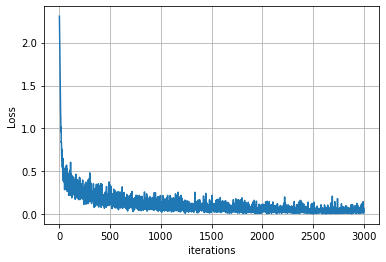

In [23]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  #loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L = [] # loss history

# Train the Model
model.train() #set the mode to training
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in tqdm(enumerate(train_loader)):  #pick a batch
        # Convert torch tensor to Variable

        images = toTensor(images.view(-1, 28*28))
        labels = toTensor(labels,dtype=torch.long)

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = model(images)
        loss = criterion(outputs, labels)
        L.append(loss.item())
        loss.backward()
        optimizer.step()

plt.plot(L);plt.xlabel('iterations');plt.ylabel('Loss');plt.grid()

In [10]:

# Test the Model
model.eval() #set the mode to evaluation
correct = 0
total = 0
for images, labels in test_loader:
    images = toTensor(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (toNumpy(predicted) == toNumpy(labels)).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# Save the Model
#torch.save(model.state_dict(), 'model.pkl')

<ipython-input-7-a764a003a643>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))


Accuracy of the network on the 10000 test images: 97 %


In [24]:
from torch.utils.data import Dataset, DataLoader
import pickle

class train_dataset(Dataset):

    def __init__(self):
        # load the preprocessed (tokenized) data
        with open("preprocessing-glove.pkl", 'rb') as inp_file:
            temp_dicts = pickle.load(inp_file)
            [_,_,_,_,_, txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_dev] = temp_dicts
        with open("preprocessing-glove.pkl", 'rb') as inp_file:
            temp_dicts = pickle.load(inp_file)
            [y_train, y_test1, y_test2, y_test3, y_dev, IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_dev] = temp_dicts
        self.x =

    def __getitem__(self, item):
        pass

    def __len__(self):
        pass





# with open("preprocessing-glove.pkl", 'rb') as inp_file:
#     temp_dicts = pickle.load(inp_file)
#     [_,_,_,_,_, txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_dev] = temp_dicts
# with open("preprocessing-glove.pkl", 'rb') as inp_file:
#     temp_dicts = pickle.load(inp_file)
#     [y_train, y_test1, y_test2, y_test3, y_dev, IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_dev] = temp_dicts


In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class ToyNN(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers):
        super(self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)

    def forward(self, inp, hidden):
        return self.gru(self.embedding(inp), hidden)

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
